## 1. Tổng quan bộ dataset

- Books data: Cung cấp tổng quan chi tiết về thông tin sách bao gồm tên sách, năm xuất bản cũng như tác giả của cuốn sách
- Users data: Cung cấp tổng quan chi tiết về từng người dùng, chẳng hạn như vị trí của người dùng cũng như độ tuổi của người dùng
- Rating data: Dữ liệu được tổng hợp cơ bản về cách mỗi người dùng xếp hạng từng cuốn sách

In [70]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import SimpleImputer
import missingno as msno

Load từng dataset lên

In [71]:
df_books = pd.read_csv('../archive/Books.csv', delimiter=",", usecols = [0,1,2,3,4])
df_Users = pd.read_csv("../archive/Users.csv")
df_rating = pd.read_csv("../archive/Ratings.csv")

C:\Users\kieub\AppData\Local\Temp\ipykernel_15508\47795284.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_books = pd.read_csv('../archive/Books.csv', delimiter=",", usecols = [0,1,2,3,4])


## 2. Tiền xử lý data

### 2.1 Books dataset

In [72]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
dtypes: object(5)
memory usage: 10.4+ MB


Ta có thể thấy cột Year-Of-Publication đang ở dạng object, vì vậy ta cần phải chuyển nó về int

In [73]:
try:
    df_books['Year-Of-Publication']  = df_books['Year-Of-Publication'].astype(int)
except Exception as e:
    print(e)

invalid literal for int() with base 10: 'DK Publishing Inc'


Chotto, có những sách có trường Year-Of-Publication có giá trị là 'DK Publishing Inc'. Vậy ta sẽ in thử những quyển đó là quyển nào

In [74]:
print(df_books[df_books['Year-Of-Publication'] == 'DK Publishing Inc'])

              ISBN                                         Book-Title   
209538  078946697X  DK Readers: Creating the X-Men, How It All Beg...  \
221678  0789466953  DK Readers: Creating the X-Men, How Comic Book...   

       Book-Author Year-Of-Publication   
209538        2000   DK Publishing Inc  \
221678        2000   DK Publishing Inc   

                                                Publisher  
209538  http://images.amazon.com/images/P/078946697X.0...  
221678  http://images.amazon.com/images/P/0789466953.0...  


Giờ ta sẽ chuyển data ở cột Year-Of-Publication sang dạng số, data nào không convert được sẽ ở dạng NaN

In [75]:
df_books['Year-Of-Publication'] = pd.to_numeric(df_books['Year-Of-Publication'],errors='coerce')
print(df_books.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 271360 non-null  object 
 1   Book-Title           271360 non-null  object 
 2   Book-Author          271358 non-null  object 
 3   Year-Of-Publication  271357 non-null  float64
 4   Publisher            271358 non-null  object 
dtypes: float64(1), object(4)
memory usage: 10.4+ MB
None


Có thể thấy cột Year-Of-Publication tuy convert sang số nhưng lại ở dạng float64, bây giờ chúng ta sẽ loại bỏ các record có value là NaN và ép kiểu cột này thành int32

In [76]:
df_books = df_books.dropna()
df_books['Year-Of-Publication'] = df_books['Year-Of-Publication'].astype(int)
print(df_books.info())

<class 'pandas.core.frame.DataFrame'>
Index: 271353 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271353 non-null  object
 1   Book-Title           271353 non-null  object
 2   Book-Author          271353 non-null  object
 3   Year-Of-Publication  271353 non-null  int32 
 4   Publisher            271353 non-null  object
dtypes: int32(1), object(4)
memory usage: 11.4+ MB
None


In [77]:
df_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


Vậy là xử lý xong trường Year-Of-Publication của Books dataset

Giờ vẽ thử cái đồ thị biểu thị số lượng sách được phân phối ở mỗi năm

<BarContainer object of 116 artists>

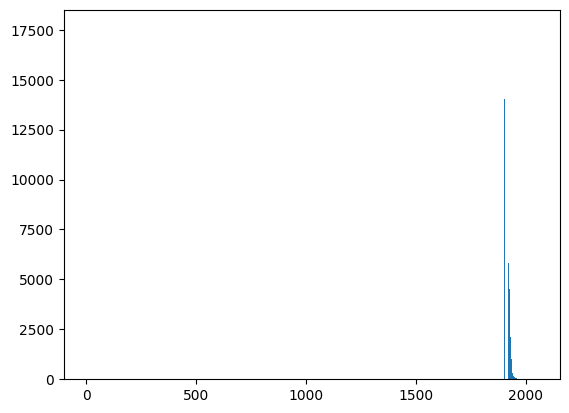

In [78]:
plt.bar(pd.DataFrame(df_books['Year-Of-Publication'].value_counts()).sort_index().index, np.array(df_books['Year-Of-Publication'].value_counts()), width = 1)

Có 2 điểm nhận xét ở đồ thị ở trên:
- Hầu hết sách được publish từ 1700~2000s
- Vẫn có những quyển publish bé hơn 1000s, nên giờ ta sẽ impute value của những record này

In [79]:
# Tạo bản sao của cột "Year-Of-Publication"
df_books_imputed = df_books.copy()

# Thay thế các giá trị năm xuất bản dưới 1000 bằng NaN
df_books_imputed.loc[df_books_imputed['Year-Of-Publication'] < 1000, 'Year-Of-Publication'] = np.nan

# Tính mode mean của cột "Year-Of-Publication"
year_mean = df_books_imputed['Year-Of-Publication'].mode()[0]

# Thay thế các giá trị NaN bằng mode mean
df_books_imputed['Year-Of-Publication'].fillna(year_mean, inplace=True)

df_books = df_books_imputed

print(df_books.loc[df_books['Year-Of-Publication'] < 1000])


Empty DataFrame
Columns: [ISBN, Book-Title, Book-Author, Year-Of-Publication, Publisher]
Index: []


Sử dụng thư viện missingno để kiểm tra Books dataset lần cuối

<Axes: >

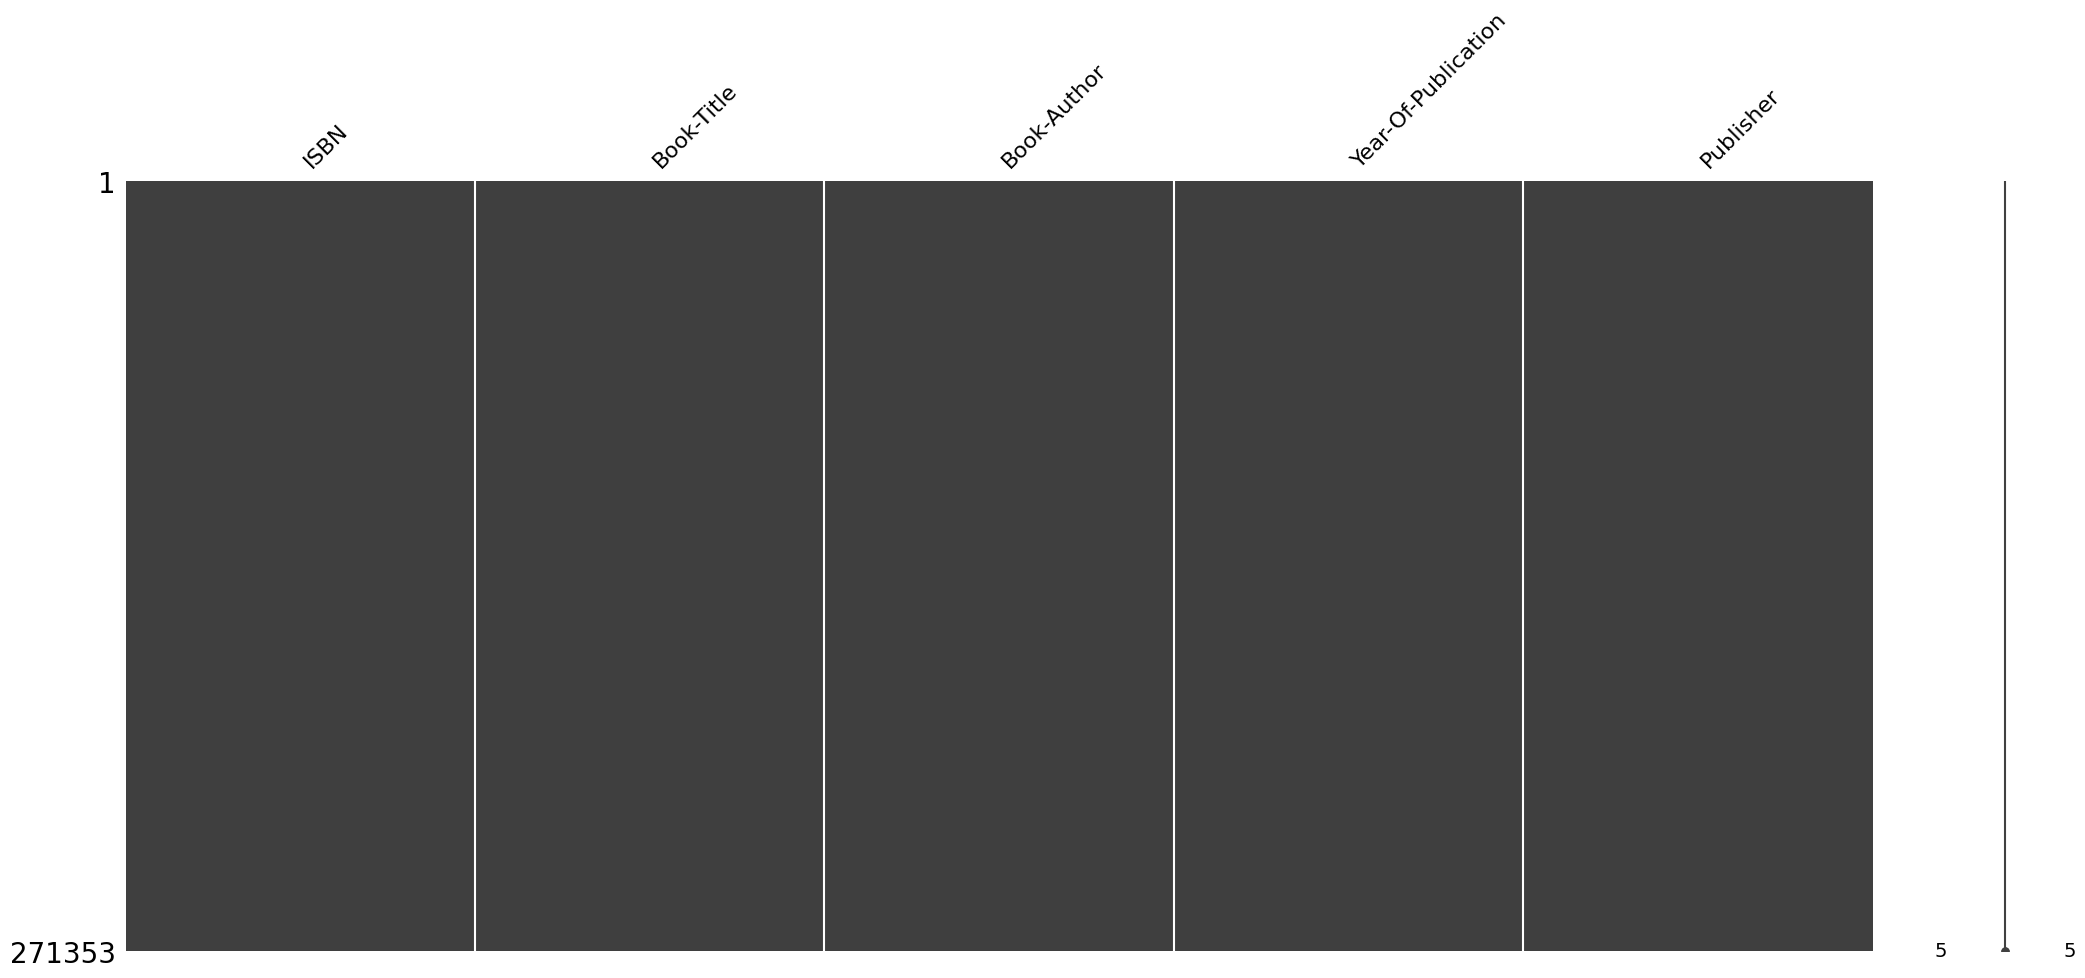

In [80]:
msno.matrix(df_books)

### 2.2 Users dataset

In [81]:
df_Users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


Dễ dàng thấy được trường Age đang ở kiểu float64 và tuổi thì làm sao có kiểu thập phân được nhỉ :)), vậy nên ta sẽ ép kiểu nó sang int32

In [82]:
df_Users['Age'] = df_Users['Age'].astype('Int32')
df_Users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   User-ID   278858 non-null  int64 
 1   Location  278858 non-null  object
 2   Age       168096 non-null  Int32 
dtypes: Int32(1), int64(1), object(1)
memory usage: 5.6+ MB


Giờ ta sẽ dùng thư viện missingno để check xem có record nào bị trống data không

<Axes: >

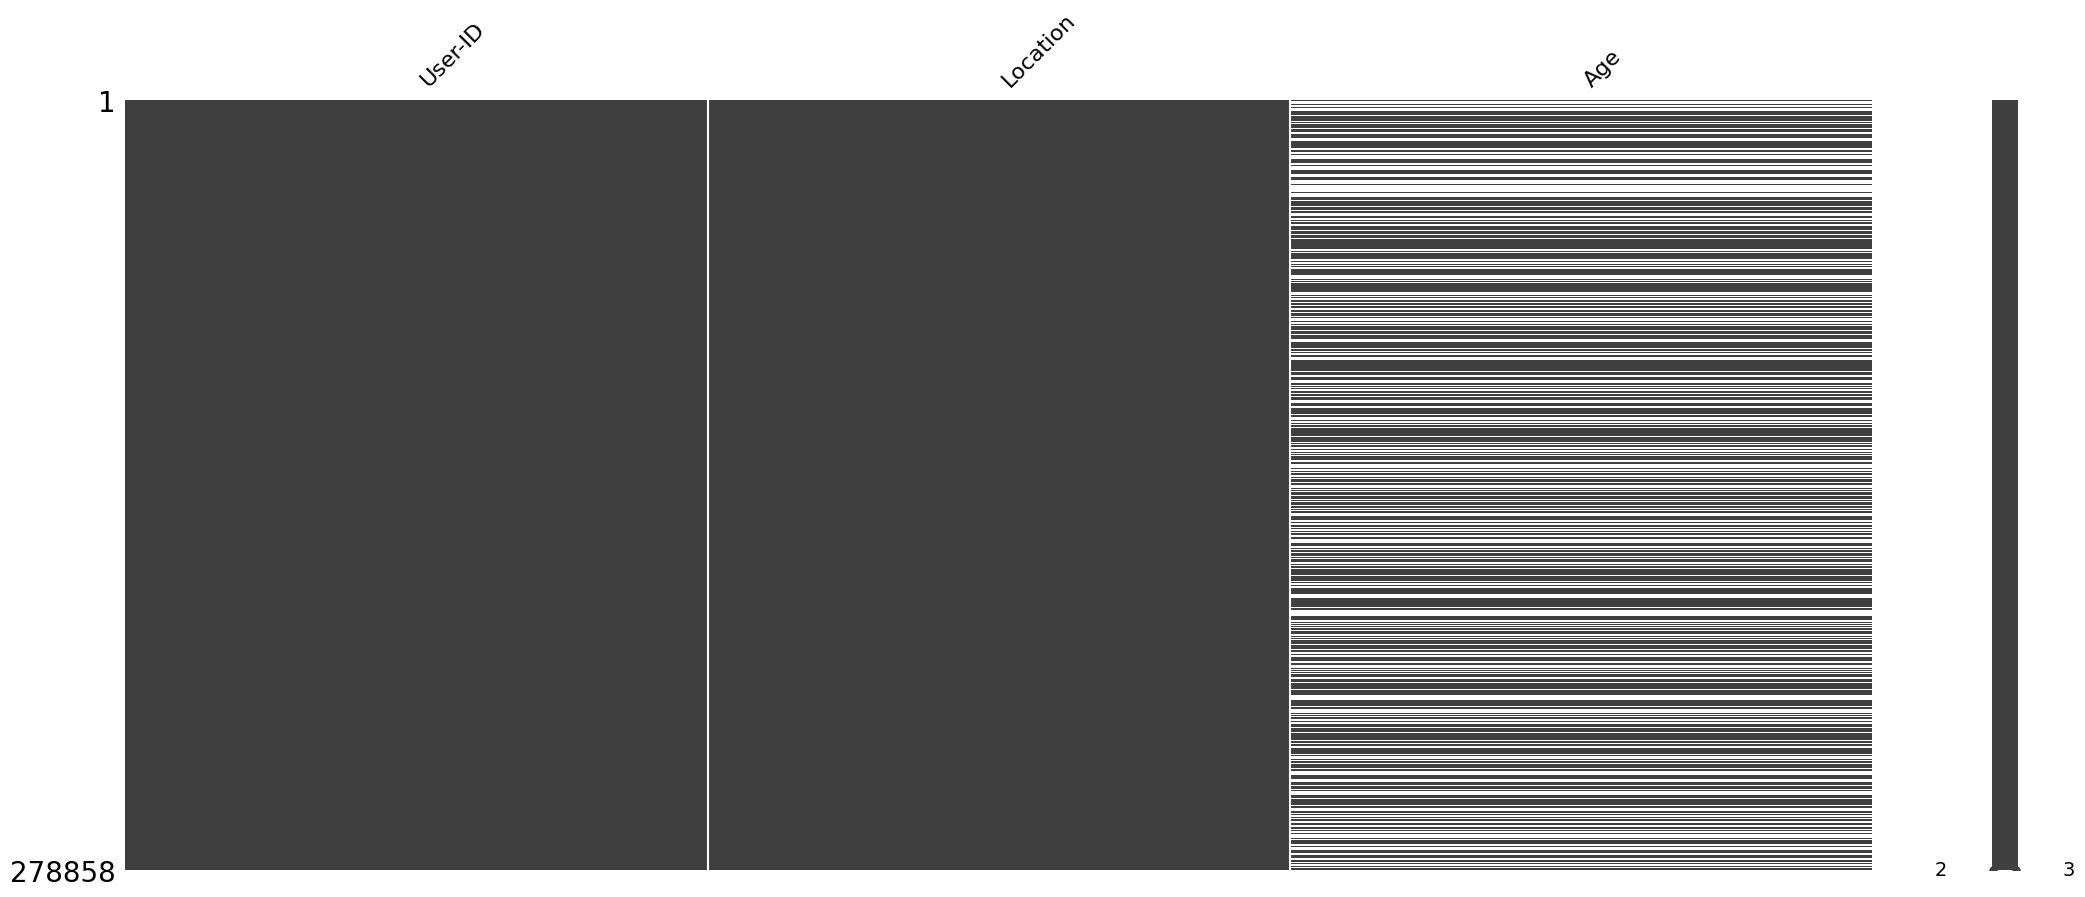

In [83]:
msno.matrix(df_Users)

Nhìn hình ta thấy, trường Age bị trống quá chời vậy ta sẽ fill nó bằng cách lấy trung bình

<Axes: >

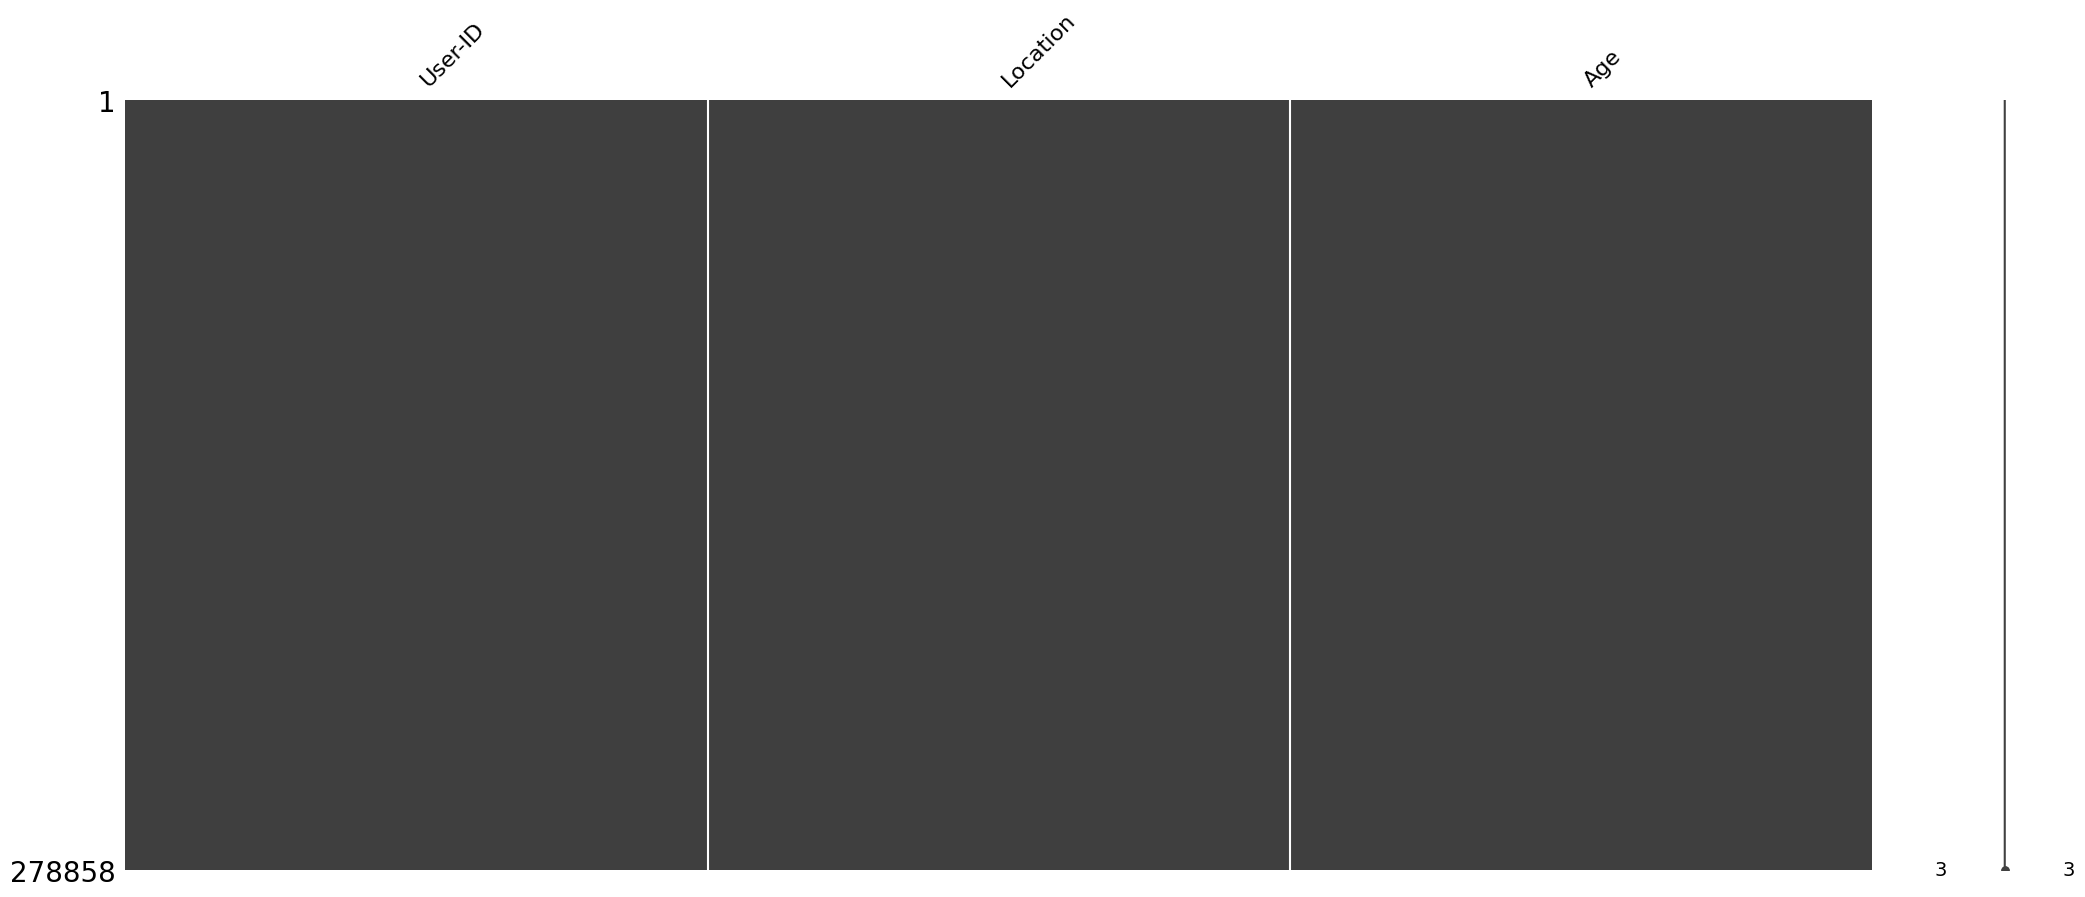

In [84]:
# Tính giá trị trung bình của trường Age
age_mean = df_Users['Age'].mean()

# Làm tròn dưới giá trị trung bình
age_mean = math.floor(age_mean)

# Điền giá trị trung bình hoặc median vào những giá trị trống
df_Users['Age'].fillna(age_mean, inplace=True)

# In ra kết quả
msno.matrix(df_Users)

### 2.3 Rating dataset

In [85]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [86]:
df_rating.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


Lúc trước khi xử lý Books và Users dataset thì ta có xóa các record của Books dataset có data lỗi nên giờ ta sẽ "clean" lại Rating dataset bằng cách remove những book đã được remove trước đó

In [87]:
print('Number of data before cleaning : {}'.format(len(df_rating)))
df_rating = df_rating[df_rating['ISBN'].isin(df_books['ISBN'])]
print('Number of data after cleaning : {}'.format(len(df_rating)))

Number of data before cleaning : 1149780
Number of data after cleaning : 1031128


Giờ ta sẽ clean Rating dataset theo 2 tiêu chí sau:
- Một quyển sách được xem là tin cậy khi nó được
vote bởi ít nhất 10 users
- Một user đáng tin cậy khi user đó đã vote ít nhất
10 books

In [88]:
f = ['count','mean']

# Tạo một dataframe mới chứa các thông tin về số lượng và điểm trung bình của mỗi cuốn sách
df_books_summary = df_rating.groupby('ISBN')['Book-Rating'].agg(f)
df_books_summary.index = df_books_summary.index.map(str)

# drop_book_list là danh sách các cuốn sách có số lượng đánh giá ít hơn 10
drop_book_list = df_books_summary[df_books_summary['count'] < 10].index

# Tạo một dataframe mới chứa các thông tin về số lượng và điểm trung bình của mỗi người dùng
df_cust_summary = df_rating.groupby('User-ID')['Book-Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)

# drop_cust_list là danh sách các người dùng có số lượng đánh giá ít hơn 10
drop_cust_list = df_cust_summary[df_cust_summary['count'] < 10].index


In [89]:
print('Before Filtering: {}'.format(df_rating.shape))
# df_rating là dataframe chứa các cuốn sách và người dùng có số lượng đánh giá lớn hơn 10
# ~ là phủ định
df_rating = df_rating[~df_rating['ISBN'].isin(drop_book_list)]
df_rating = df_rating[~df_rating['User-ID'].isin(drop_cust_list)]
print('After Filtering: {}'.format(df_rating.shape))
df_rating.head()

Before Filtering: (1031128, 3)
After Filtering: (428085, 3)


,User-ID,ISBN,Book-Rating
31,276762,034544003X,0
33,276762,0380711524,5
34,276762,0451167317,0
89,276798,3423084049,0
97,276798,3548603203,6


In [90]:
# pivot_rating là dataframe chứa các giá trị đánh giá của các cuốn sách theo từng người dùng
pivot_rating = df_rating.pivot(index='ISBN',columns='User-ID',values='Book-Rating')
pivot_rating.head()

User-ID,8,99,242,243,254,383,388,408,424,446,...,278522,278535,278554,278563,278582,278633,278637,278771,278843,278851
ISBN,,,,,,,,,,,,,,,,,,,,,
0002005018,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0002251760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0002255081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0002257203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0002259834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Xây dựng model

### 3.1 Content-based

Ý tưởng đơn giản của giải thuật content_based sẽ là:
- Pick ra một user
- Tìm ra quyển sách user được vote cao nhất
- Tìm những quyển sách giống với quyển sách được user vote cao nhất
- Recommend những quyển này tới cho user

Một user có thể có xu hướng đọc một quyển sách khác dựa trên những yếu tố sau:
- Authors: dễ hình dung là bởi mỗi tác giả sẽ có một phong cách riêng nên việc một user thích phong cách của tác giả này thì sẽ có khả năng thích những quyển còn lại của tác giả đó luôn
- Year-Of-Publication: năm xuất bản có khả năng phản ảnh một phần thể loại của quyển sách. Ví dụ dễ hiểu là là những quyển sách triết lý cổ điển thì thường có năm xuất bản lâu đời
- Publisher: nhà xuất bản thì chứa một điểm uy tín nhất định đối với những người đọc có chọn lọc

Như vậy 3 yếu tố Authors, Year-Of-Publication, Publisher là các yếu tố nền tảng cho giải thuật

In [91]:
len(df_books['ISBN'])

271353

Lúc trước chúng ta đã clean Rating dataset bằng cách loại bỏ những rating không đáng tin cậy. Bây giờ khi recommend cho user chúng ta chỉ sử dụng những quyển sách có trong Rating dataset thôi

In [92]:
print ("number of books: " + str(len(df_books[df_books['ISBN'].isin(df_rating['ISBN'])].copy())))

number of books: 17478


In [93]:
features = ['Book-Author', 'Year-Of-Publication', 'Publisher', 'Book-Title']

# df_books_preprocess là dataframe chứa các cuốn sách có trong df_rating
df_books_preprocess = df_books[df_books['ISBN'].isin(df_rating['ISBN'])].copy()

for feature in features:
    # Nếu feature là kiểu dữ liệu object
    if df_books_preprocess[feature].dtype == 'O':
        # Thay thế các ký tự đặc biệt bằng ''
        df_books_preprocess[feature] = df_books_preprocess[feature].str.replace('\W', '', regex=True)
        # Chuyển về chữ thường
        df_books_preprocess[feature] = df_books_preprocess[feature].apply(lambda x: str.lower(x))

Tạo ra một cột mới trong dataframe df_books_preprocess có tên là soup. Cột này được tạo ra bằng cách kết hợp thông tin từ các trường Book-Author, Year-Of-Publication, và Publisher của mỗi quyển sách thành một chuỗi đại diện cho nội dung của sách, được gọi là "soup". Đây là bước tiền xử lý dữ liệu để sử dụng trong việc tính toán độ tương đồng giữa các quyển sách trong quá trình gợi ý sách cho người dùng.

In [94]:
# create_soup là hàm tạo một cột chứa các thông tin của các feature
def create_soup(x):
    # x là một dòng của dataframe
    return x['Book-Author'] + ' ' + str(x['Year-Of-Publication'])+ ' ' + x['Publisher']

# df_books_preprocess['soup'] là một cột chứa các thông tin của các feature
# apply(create_soup, axis = 1) là áp dụng hàm create_soup cho từng dòng của dataframe
# axis = 1 là áp dụng hàm create_soup cho từng dòng
df_books_preprocess['soup'] = df_books_preprocess[features].apply(create_soup, axis = 1)

df_books_preprocess.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,soup
1,0002005018,claracallan,richardbrucewright,2001.0,harperflamingocanada,richardbrucewright 2001.0 harperflamingocanada
3,0374157065,fluthestoryofthegreatinfluenzapandemicof1918an...,ginabarikolata,1999.0,farrarstrausgiroux,ginabarikolata 1999.0 farrarstrausgiroux
5,0399135782,thekitchengodswife,amytan,1991.0,putnampubgroup,amytan 1991.0 putnampubgroup
18,0440234743,thetestament,johngrisham,1999.0,dell,johngrisham 1999.0 dell
19,0452264464,belovedplumecontemporaryfiction,tonimorrison,1994.0,plume,tonimorrison 1994.0 plume


Ta sẽ sử dụng cột soup để tạo ma trận đếm số từ xuất hiện của từng quyển sách

In [95]:
from sklearn.feature_extraction.text import CountVectorizer

# Tạo một ma trận chứa các từ xuất hiện trong các cuốn sách
# stop_words='english' là loại bỏ các từ không cần thiết
# count_matrix là ma trận chứa các từ xuất hiện trong các cuốn sách
# count_matrix[i][j] là số lần từ j xuất hiện trong cuốn sách i
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df_books_preprocess['soup'])

# Tạo DataFrame từ ma trận count_matrix
count_df = pd.DataFrame(count_matrix.toarray(), index=df_books_preprocess.index, columns=count.get_feature_names_out())

# In ra 10 hàng đầu tiên của count_df
count_df.head(10)

,1920,1926,1927,1929,1930,1932,1942,1943,1946,1950,...,zoeheller,zoejenny,zoeydean,zolandbooks,zondervan,zondervanpublishingcompany,zoranealehurston,zsolnay,zsuzsannaebudapest,zzpacker
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Từ ma trận count_matrix ta có thể tính độ tương đồng giữa các cuốn sách bằng khoảng cách cosin

In [96]:
from sklearn.metrics.pairwise import cosine_similarity

# Tính độ tương đồng giữa các cuốn sách
# cosine_sim2 là ma trận chứa độ tương đồng giữa các cuốn sách
# giá trị cosine_sim2[i][j] là độ tương đồng giữa cuốn sách i và cuốn sách j
# cosine_sim2[i][j] chạy từ 0 đến 1, 1 là độ tương đồng cao nhất
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

# Chuyển ma trận cosine_sim2 thành DataFrame
cosine_sim2_df = pd.DataFrame(cosine_sim2, index=df_books_preprocess['Book-Title'], columns=df_books_preprocess['Book-Title'])
cosine_sim2_df.head()

Book-Title,claracallan,fluthestoryofthegreatinfluenzapandemicof1918andthesearchforthevirusthatcausedit,thekitchengodswife,thetestament,belovedplumecontemporaryfiction,ourdumbcenturytheonionpresents100yearsofheadlinesfromamericasfinestnewssource,newvegetarianboldandbeautifulrecipesforeveryoccasion,wildanimus,airframe,timeline,...,lãâcherdiegeheimnissevongreenlakeab12j,diesãâulendererde,imischameijerinmargineinmemoriam,amendedesschweigensroman,derspaziergangprosastãâ¼ckeundkleineprosa,cosifantutteeinegeschichte,theillustratedalchemistafableaboutfollowingyourdream,theangelmaker,theendlessstepperackgrowingupinsiberia,theicehousetvtieinedition
Book-Title,,,,,,,,,,,,,,,,,,,,,
claracallan,1.0,0.000000,0.0,0.000000,0.0,0.000000,0.333333,0.0,0.0,0.0,...,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.333333,0.0,0.0
fluthestoryofthegreatinfluenzapandemicof1918andthesearchforthevirusthatcausedit,0.0,1.000000,0.0,0.333333,0.0,0.333333,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
thekitchengodswife,0.0,0.000000,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
thetestament,0.0,0.333333,0.0,1.000000,0.0,0.333333,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
belovedplumecontemporaryfiction,0.0,0.000000,0.0,0.000000,1.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


Ta sử dụng ISBN của book để query data nhưng dataframe cosine_sim2 lại không có index hay column để query theo ISBN nên ta sẽ tạo một hashmap indices với mỗi ISBN sẽ map đúng index trên cosine_sim2

In [97]:
# df2 có cấu trúc giống như df_books_preprocess nhưng có thêm cột index để lưu chỉ số của các cuốn sách
df2 = df_books_preprocess.reset_index()

# indices là một hashmap với key là ISBN và value là chỉ số của cuốn sách
indices = pd.Series(df2.index, index=df2['ISBN'])

Hàm recommend_books ta sẽ truyền vào mã ISBN của sách sau đó từ mã ISBN đó mới query trong cosine_sim để tìm ra những quyển sách liên quan tới quyển có mã ISBN nhất. Sau đó lấy 10 cuốn thôi

In [98]:
# recommend_books là hàm trả về 10 cuốn sách tương tự nhất với cuốn sách có ISBN là ISBN
def recommend_books(ISBN, cosine_sim):
    # idx là chỉ số của cuốn sách có ISBN là ISBN
    idx = indices[ISBN]

    # sim_scores là một list chứa các cặp (chỉ số, độ tương đồng)
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sắp xếp các cặp (chỉ số, độ tương đồng) theo độ tương đồng giảm dần
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Lấy 10 cặp (chỉ số, độ tương đồng) đầu tiên
    sim_scores = sim_scores[1:11]

    # book_indices là một list chứa các chỉ số của các cuốn sách tương tự nhất
    book_indices = [i[0] for i in sim_scores]

    # Trả về 10 cuốn sách tương tự nhất và độ tương đồng của chúng
    return df2[['Book-Title','soup']].iloc[book_indices], sim_scores

In [110]:
# get_recommendations là hàm trả về 10 cuốn sách tương tự nhất với cuốn sách mà người dùng có User-ID là userid đánh giá cao nhất
def get_recommendations(userid, cosine_sim):
    # ISBN là cuốn sách mà người dùng có User-ID là userid đánh giá cao nhất
    ISBN = df_rating['ISBN'].loc[df_rating[df_rating['User-ID'] == userid]['Book-Rating'].idxmax()]

    # recommendation là 10 cuốn sách tương tự nhất với cuốn sách có ISBN là ISBN
    # sim_score là độ tương đồng của 10 cuốn sách tương tự nhất với cuốn sách có ISBN là ISBN
    recommendation, sim_score = recommend_books(ISBN, cosine_sim)

    # df_recommend là dataframe chứa 10 cuốn sách tương tự nhất với cuốn sách có ISBN là ISBN
    df_recommend = pd.DataFrame(recommendation)
    # Thêm cột Cosine_Similarity chứa độ tương đồng của 10 cuốn sách tương tự nhất với cuốn sách có ISBN là ISBN
    df_recommend['Cosine_Similarity'] = sim_score
    # hàm apply(lambda x: x[1]) là lấy phần tử thứ 2 của cặp (chỉ số, độ tương đồng)
    df_recommend['Cosine_Similarity'] = df_recommend['Cosine_Similarity'].apply(lambda x: x[1])

    return df_recommend

Ok, giờ thử với user-id 8

In [111]:
pd.concat([df_books[df_books['ISBN'].isin(list(df_rating[df_rating['User-ID'] == 8]['ISBN']))].reset_index(drop=True),df_rating[df_rating['User-ID'] == 8]['Book-Rating'].reset_index(drop=True)], axis = 1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Book-Rating
0,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,5
1,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,0
2,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,0


Thằng này đọc 3 quyển và rate quyển Clara Callan cao nhất

In [112]:
df_recommend = get_recommendations(8, cosine_sim2)
df_recommend

,Book-Title,soup,Cosine_Similarity
15353,spadework,timothyfindley 2001.0 harperflamingocanada,0.666667
6,newvegetarianboldandbeautifulrecipesforeveryoc...,celiabrooksbrown 2001.0 rylandpetersampsmallltd,0.333333
19,fromthecornerofhiseye,deankoontz 2001.0 bantambooks,0.333333
44,elsenordelosanilloslacomunidaddelanillolordoft...,jrrtolkien 2001.0 minotauro,0.333333
45,elsenordelosanilloslasdostorreslordoftheringsp...,jrrtolkien 2001.0 minotauro,0.333333
46,elsenordelosanilloselretornodelreytolkienjrrlo...,jrrtolkien 2001.0 distribooks,0.333333
49,fastwomen,jennifercrusie 2001.0 stmartinspress,0.333333
50,femaleintelligence,janeheller 2001.0 stmartinspress,0.333333
63,angelsampdemons,danbrown 2001.0 pocketstar,0.333333
75,beforeisaygoodbye,maryhigginsclark 2001.0 pocket,0.333333
